In [1]:
%cd drive/My Drive/GAN series/Cycle GAN

/content/drive/My Drive/GAN series/Cycle GAN


In [2]:
%ls

CycleGAN.ipynb  horse2zebra/


In [0]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

## Hyperparameters

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
num_workers = 0
image_size= 256
input_dim = (3, 256, 256)
num_epochs = 3000

lr=0.0002
beta1=0.5
beta2=0.999

## Load and Visualize Data

Dataset horse2zebra can be download from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)

In [0]:
def get_data(image_dir, type, image_size = image_size, batch_size = batch_size, num_workers = num_workers):
    '''
        Return training and test dataloader for image type ("horse"(A) and "zebra"(B))
    '''
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image_path = './' + image_dir
    train_path = os.path.join(image_path, "train{}".format(type))
    test_path = os.path.join(image_path, "test{}".format(type))
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_dataloader = DataLoader(train_dataset, batch_size, shuffle= True, num_workers= num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers= num_workers)
    return train_dataloader, test_dataloader 

In [0]:
train_dataloader_A, test_dataloader_A = get_data("horse2zebra", type= "A")
train_dataloader_B, test_dataloader_B = get_data("horse2zebra", type= "B")

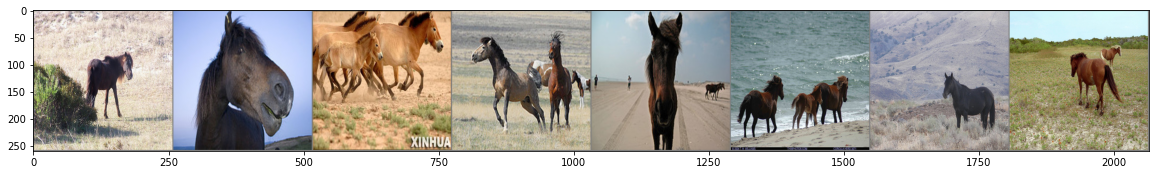

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_dataloader_A)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(20, 12))
imshow(torchvision.utils.make_grid(images))

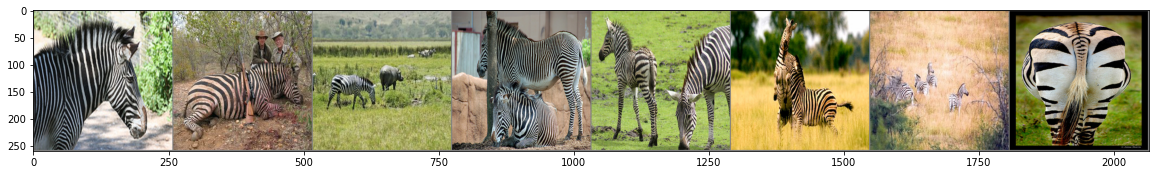

In [8]:
dataiter = iter(train_dataloader_B)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(20, 12))
imshow(torchvision.utils.make_grid(images))

## Define the model

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02).to(device)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02).to(device)
        nn.init.constant_(m.bias.data, 0).to(device)

### Discriminator 

In [0]:
def discriminator_block(in_channels, out_channels, kernel_size, stride, padding,
                        normalize = True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size= kernel_size, 
                        stride= stride, padding= padding)]
    if normalize:
        layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace= True))
    return layers

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_dim = (3, 256, 256)):
        super(Discriminator, self).__init__()
        channels, height, width = input_dim

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 64, 4, 2, 1),    #64 x 128 x 128
            *discriminator_block(64, 128, 4, 2, 1),    #128 x 64 x 64
            *discriminator_block(128, 256, 4, 2, 1),    #256 x 32 x 32
            *discriminator_block(256, 512, 4, 2, 1),    #512 x 16 x 16
            nn.ZeroPad2d((1, 0, 1, 0)),    #512 x 17 x 17
            *discriminator_block(512, 512, 4, 1, 1),    #512 x 16 x 16
            nn.ZeroPad2d((1, 0, 1, 0)), #512 x 17 x 17
            nn.Conv2d(512, 1, 4, 1, 1)    #1 x 16 x 16
        )
    def forward(self, img):
        return self.conv_blocks(img)

### Generator

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_out_channels, in_out_channels, kernel_size= 3, stride= 1, padding= 1)
        self.conv2 = nn.Conv2d(in_out_channels, in_out_channels, kernel_size= 3, stride= 1, padding= 1)
        self.norm1 = nn.InstanceNorm2d(in_out_channels)
        self.norm2 = nn.InstanceNorm2d(in_out_channels)
    
    def forward(self, x):
        out1 = F.relu(self.norm1(self.conv1(x)))
        out2 = x + self.norm2(self.conv2(out1))
        return out2

In [0]:
class Generator(nn.Module):
    def __init__(self, input_dim= (3, 256, 256), num_residual_blocks= 9):
        super(Generator, self).__init__()
        channels, height, width = input_dim
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size= 7, stride= 1, padding= 3),    #64 x 256 x 256
            nn.InstanceNorm2d(64),     #64 x 256 x 256
            nn.ReLU(inplace= True),

            nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1),     #128 x 128 x 128
            nn.InstanceNorm2d(128),    #128 x 128 x 128
            nn.ReLU(inplace= True),

            nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 1),    #256 x 64 x 64
            nn.InstanceNorm2d(256),    #256 x 64 x 64
            nn.ReLU(inplace = True)
        )
        
        res_layers = []
        for _ in range(num_residual_blocks):
            res_layers.append(ResidualBlock(256))
        self.res_blocks = nn.Sequential(*res_layers)    #256 x 64 x 64

        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size= 3, stride= 2, padding= 1, output_padding= 1),    #128 x 128 x 128
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(128, 64, kernel_size= 3, stride= 2, padding= 1, output_padding= 1),    #64 x 256 x 256
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(64, 3, kernel_size= 7, stride= 1, padding= 3),    #3 x 256 x 256
            nn.Tanh()
        )
    
    def forward(self, x):
        out = self.conv_encoder(x)
        out = self.res_blocks(out)
        out = self.conv_decoder(out)
        return out

### Create Models

In [14]:
G_AtoB = Generator(input_dim, 9).to(device)
G_BtoA = Generator(input_dim, 9).to(device)
D_A = Discriminator(input_dim).to(device)
D_B = Discriminator(input_dim).to(device)

G_AtoB.apply(weights_init)
G_BtoA.apply(weights_init)
D_A.apply(weights_init)
D_B.apply(weights_init)

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (1

In [15]:
print("------------G_AtoB-------------")
print(G_AtoB)
print("------------G_BtoA-------------")
print(G_BtoA)
print("--------------D_A---------------")
print(D_A)
print("--------------D_B---------------")
print(D_B)

------------G_AtoB-------------
Generator(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (no

## Define Losses and Optimizers

In [0]:
def real_loss(D_out):
    return torch.mean((D_out - 1)**2)

def fake_loss(D_out):
    return torch.mean(D_out **2)

def cycle_loss(real_img, reconstructed_img, lam):
    loss = torch.mean(torch.abs(real_img - reconstructed_img))
    return lam*loss

In [0]:
g_params = list(G_AtoB.parameters()) + list(G_BtoA.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_a_optimizer = optim.Adam(D_A.parameters(), lr, [beta1, beta2])
d_b_optimizer = optim.Adam(D_B.parameters(), lr, [beta1, beta2])

## Training

In [18]:
G_AtoB.train().to(device)
G_BtoA.train().to(device)
D_A.train().to(device)
D_B.train().to(device)

iter_A = iter(train_dataloader_A)
iter_B = iter(train_dataloader_B)
batches_per_epoch = min(len(iter_A), len(iter_B))

for epoch in range(num_epochs):
    if epoch % batches_per_epoch == 0:
        iter_A = iter(train_dataloader_A)
        iter_B = iter(train_dataloader_B)
    
    images_A, _ = iter_A.next()
    images_B, _ = iter_B.next()

    images_A = images_A.to(device)
    images_B = images_B.to(device)

    # TRAIN DISCRIMINATOR
    #TRAIN D_A
    #Train with real images
    d_a_optimizer.zero_grad()

    D_out_a = D_A(images_A)
    D_A_real_loss = real_loss(D_out_a)

    #Train with fake image
    fake_A = G_BtoA(images_B)

    D_out_A = D_A(fake_A)
    D_A_fake_loss = fake_loss(D_out_A)

    #Combine both losses
    D_A_loss = D_A_real_loss + D_A_fake_loss
    D_A_loss.backward()
    d_a_optimizer.step()

    #TRAIN D_B
    #Train with real images
    d_b_optimizer.zero_grad()

    D_out_b = D_B(images_B).to(device)
    D_B_real_loss = real_loss(D_out_b)

    #Train with fake images
    fake_B = G_AtoB(images_A)

    D_out_B = D_B(fake_B)
    D_B_fake_loss = fake_loss(D_out_B)

    #Combine both losses
    D_B_loss = D_B_real_loss + D_B_fake_loss
    D_B_loss.backward()
    d_b_optimizer.step()

    #TRAIN GENERATOR
    #train fake A
    g_optimizer.zero_grad()

    fake_A = G_BtoA(images_B)

    out_A = D_A(fake_A)
    g_BtoA_loss = real_loss(out_A)

    reconstructed_B = G_AtoB(fake_A)
    reconstructed_B_loss = cycle_loss(images_B, reconstructed_B, 10)

    #train fake B
    fake_B = G_AtoB(images_A)

    out_B = D_B(fake_B)
    g_AtoB_loss = real_loss(out_B)

    reconstructed_A = G_BtoA(fake_B)
    reconstructed_A_loss = cycle_loss(images_A, reconstructed_A, 10)

    #Combine all losses
    g_total_loss = g_BtoA_loss + reconstructed_B_loss + g_AtoB_loss + reconstructed_A_loss
    g_total_loss.backward()
    g_optimizer.step()

    if epoch %10 == 0:
        print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
            epoch, num_epochs, D_A_loss.item(), D_B_loss.item(), g_total_loss.item()))

Epoch [    0/ 3000] | d_X_loss: 3.2342 | d_Y_loss: 3.0284 | g_total_loss: 26.0319
Epoch [   10/ 3000] | d_X_loss: 1.7916 | d_Y_loss: 2.8479 | g_total_loss: 12.9953
Epoch [   20/ 3000] | d_X_loss: 1.5527 | d_Y_loss: 2.0127 | g_total_loss: 9.7079
Epoch [   30/ 3000] | d_X_loss: 1.1204 | d_Y_loss: 1.0828 | g_total_loss: 8.0364
Epoch [   40/ 3000] | d_X_loss: 1.8462 | d_Y_loss: 1.0614 | g_total_loss: 9.3849
Epoch [   50/ 3000] | d_X_loss: 1.2538 | d_Y_loss: 0.9094 | g_total_loss: 7.0064
Epoch [   60/ 3000] | d_X_loss: 0.7779 | d_Y_loss: 1.1134 | g_total_loss: 7.1987
Epoch [   70/ 3000] | d_X_loss: 0.8767 | d_Y_loss: 0.9293 | g_total_loss: 6.7319
Epoch [   80/ 3000] | d_X_loss: 0.7359 | d_Y_loss: 0.7585 | g_total_loss: 6.5116
Epoch [   90/ 3000] | d_X_loss: 0.8372 | d_Y_loss: 1.3285 | g_total_loss: 8.8018
Epoch [  100/ 3000] | d_X_loss: 0.6469 | d_Y_loss: 1.0149 | g_total_loss: 6.6227
Epoch [  110/ 3000] | d_X_loss: 0.6099 | d_Y_loss: 0.6949 | g_total_loss: 5.9240
Epoch [  120/ 3000] | d_X_

## Evaluation

In [0]:
dataiter = iter(test_dataloader_A)

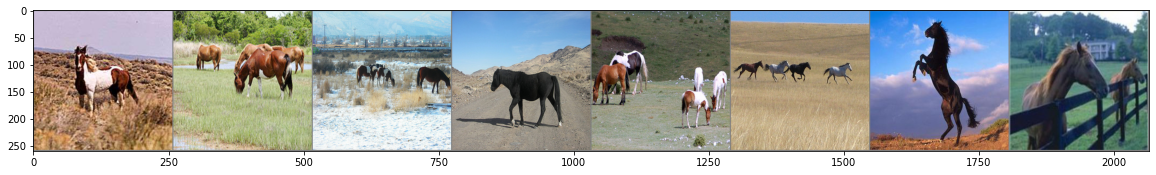

In [43]:
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(20, 12))
imshow(torchvision.utils.make_grid(images))

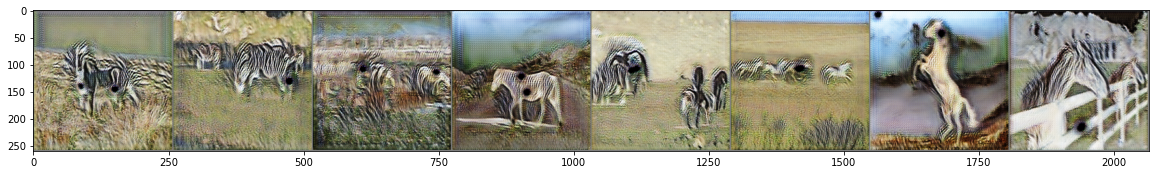

In [44]:
G_AtoB.eval()
G_BtoA.eval()
fakes = G_AtoB(images.to(device))
fig = plt.figure(figsize=(20, 12))
imshow(torchvision.utils.make_grid(fakes.detach()))

Not good! You should trainning more epochs and tunning carefully.